# Planning-Lab lesson 4: Reinforcement Learning

In this tutorial we will implement two model free RL algorithms: Q-Learning and SARSA.

## Cliff Environment
The environment used is **Cliff** (taken from the book of Sutton and Barto as visible in the figure)

![Cliff](images/cliff.png)

The agent starts in cell $(3, 0)$ and has to reach the goal in $(3, 11)$. Falling from the cliff resets the position to the start state (the episode ends only when the goal state is reached). All other cells are safe. **Action dinamycs is deterministic**, meaning that the agent always reaches the desired next state.

In [4]:
import os, sys
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

env = gym.make("Cliff-v0")
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



The cell types are the following:

- x - Start position
- o - Safe
- C - Cliff
- T - Goal

Rewards:

- -1 for each "safe" cell (o)
- -100 for falling from the cliff (C)

In addition to the functionalities of the environments you have been using in the previous sessions, there are also a few more:

- step(action): the agent **execute action in the environment** from the current state. Returns a tuple (new_state, reward, done, info) where:
    - new_state: is the new state reached as a consequence of the agent's last action
    - reward: the reward obtained by the agent
    - done: True if the episode has ended, False otherwise
    - info: not used, you can safely discard it

- reset(): the environment is reset and the agent goes back to the starting position. Returns the initial state id

In [5]:
state = env.reset()
action = 0 # Go UP
new_state, reward, done, _ = env.step(0)

print("State: {} \nAction: {} \nNew State: {} \nReward: {} \nDone: {}".format(env.state_to_pos(state), action, env.state_to_pos(new_state), reward, done))

State: (3, 0) 
Action: 0 
New State: (2, 0) 
Reward: -1 
Done: False


Suppose we want to execute a random policy in the environment: we create such policy as usual, we reset the environment to its initial state and also set a maximum number of steps for the episod. Then we execute a loop where at each iteration a step is performed by using the action prescribed by the policy.

In [6]:
policy = np.random.choice(env.action_space.n, env.observation_space.n)
state = env.reset()
ep_limit = 20 #maximum number of steps the policy will execute

el = 0 #initialize counter to accumulate the number of steps the policy execute (episode length)
total_reward = 0 #initialize accumulate to sum the rewards received at each step 

# Episode execution loop
for _ in range(ep_limit):
    next_state, reward, done, _ = env.step(policy[state])  # Execute a step
    total_reward += reward
    el += 1
    if done or el == ep_limit:  # If done == True, the episode has ended
        break
    state = next_state
    
print("Policy: \n {} \n Total Reward of Random Policy: : {} \n Episode Length {} ".format(policy.reshape(4,12),total_reward,el))

Policy: 
 [[0 0 2 2 0 2 2 2 0 2 0 3]
 [0 1 0 1 3 1 3 0 3 2 0 1]
 [3 1 2 0 3 0 1 1 1 0 1 2]
 [2 3 2 2 3 0 3 2 3 2 1 3]] 
 Total Reward of Random Policy: : -20 
 Episode Length 20 


# Assignment 1:  Q-Learning
Your first assignment is to implement the Q-Learning algorithm on **Cliff**. You can use the implement exploration functions: $\epsilon$-greedy and Softmax. 

The solution returned by your Q-Learning implementation must be a tuple (policy, rewards, lengths) where:

- *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
- *rewards*: array of rewards where the $i$-th reward refers to the $i$-th episode of the training performed
- *lengths*: array of lengths where the $i$-th length refers to the $i$-th episode of the training performed (length in number of steps)

Implemented exploration functions:
- *epsilon_greedy(q, state, epsilon)*
- *softmax(softmax(q, state, temp)*

**Functions to implement:**
- *q_learning(environment, episodes, alpha, gamma, expl_func, expl_param)*

#### Note on softmax #### 
The implementation of softmax requires to **draw a number given a specific probability distribution**. We can use the random.choice(a,p) function of the NumPy library to do this. 

Where: 
- *a: an array or an int, If an array, a random sample is generated from its elements. If an int, the random sample is generated as if it were np.arange(a)*
- *p: the probabilities associated with each entry in a. If not given, the sample assumes a uniform distribution over all entries in a.*

In [7]:
#Example with a as int, choice is made on among the 5 choices in the vector [0,1,2,3,4], 
#the 3rd is the one that is most likely to be chosen (highest probability value).

q = [0.1, 0.2, 0.5, 0.1, 0.1]
c1 = np.random.choice(5, p = q)
print("Choosing among: {} with probability {}: {}".format(np.arange(5),q,c1))

a = np.random.choice(3, 5)
c2 = np.random.choice(a, p = q)
print("Choosing among: {} with probability {}: {}".format(a,q,c2))


np.set_printoptions(precision=3) #set decimal numer to 3 in array
#Example to extract the maximum value and the index with maximum value from an array 
q = np.random.rand(env.observation_space.n, env.action_space.n) # Randomly intialization of Q(s, a)
print("Values of all actions, max and argmax for the first 5 states")
for i in range(5): 
    print("q[{}]: {}, max : {:.3f}, argmax {}".format(i,q[i],q[i].max(),q[i].argmax()))

print("array of first 5 states with max value across actions: \n {} \narray of first 5 states with maximum action \n {}".format(q.max(axis=1)[:5],q.argmax(axis=1)[:5]))


Choosing among: [0 1 2 3 4] with probability [0.1, 0.2, 0.5, 0.1, 0.1]: 0
Choosing among: [1 1 2 2 2] with probability [0.1, 0.2, 0.5, 0.1, 0.1]: 2
Values of all actions, max and argmax for the first 5 states
q[0]: [0.151 0.811 0.433 0.213], max : 0.811, argmax 1
q[1]: [0.748 0.877 0.931 0.321], max : 0.931, argmax 2
q[2]: [0.313 0.65  0.332 0.735], max : 0.735, argmax 3
q[3]: [0.081 0.704 0.283 0.742], max : 0.742, argmax 3
q[4]: [0.424 0.497 0.93  0.56 ], max : 0.930, argmax 2
array of first 5 states with max value across actions: 
 [0.811 0.931 0.735 0.742 0.93 ] 
array of first 5 states with maximum action 
 [1 2 3 3 2]


**Exploration functions to be used in the algorithm:**

In [8]:
def epsilon_greedy(q, state, epsilon):
    """
    Epsilon-greedy action selection function
    
    Args:
        q: q table
        state: agent's current state
        epsilon: epsilon parameter
    
    Returns:
        action id
    """
    if np.random.random() < epsilon: #enters the if only if the random number is less than epsilon (i.e., with probability  epsilon)
        return np.random.choice(q.shape[1]) #the size of first dimension of q is number of states, the second is number of actions 
    return q[state].argmax() #q[state] is a vector of q-values indexed by actions

def softmax(q, state, temp):
    """
    Softmax action selection function
    
    Args:
    q: q table
    state: agent's current state
    temp: temperature parameter
    
    Returns:
        action id
    """
    e = np.exp(q[state] / temp) #a vector indexed by action where each value is e^(q(s,a)/T)
    return np.random.choice(q.shape[1], p=e / e.sum()) # choose an action with probability e^(q(s,a)/T)/sum_{a'} e^(q(s,a')/T)  

**The following function has to be implemented:**

In [13]:
def q_learning(environment, episodes, alpha, gamma, expl_func, expl_param):
    """
    Performs the Q-Learning algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        expl_func: exploration function (epsilon_greedy, softmax)
        expl_param: exploration parameter (epsilon or T)
    
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """
    
    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)
    #
    # Code Here!
    #
    for i in range (episodes) :
        s = environment.reset()
        done = False
        rewTot = 0
        epLength = 0
        while not done:
            epLength += 1
            a = expl_func(q, s, expl_param)
            next_state, reward, done,  _ = environment.step(a)
            rewTot += reward
            maxV = - np.inf
            for act in range (environment.action_space.n):
                maxV = max(q[next_state][act] ,maxV)
            q[s][a] = q[s][a] + alpha*(reward + gamma*maxV -q[s][a])
            s = next_state
        rews[i] = rewTot
        lengths[i] = epLength
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths

**Notice that since the executions are stochastic, the policy could differ: the important thing is that the policy obtained using Q-Learning chooses the shortest path toward the goal.**

In [14]:
env_name = "Cliff-v0"
env = gym.make(env_name)
env.render()
print()

# Learning parameters
episodes = 500
alpha = .3
gamma = .9
epsilon = .1

t = timer()

# Q-Learning epsilon greedy
policy, rewards, lengths = q_learning(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
print(f"Execution time: {round(timer() - t, 4)}s") 
policy_render = np.vectorize(env.actions.get)(policy.reshape(env.shape))
_ = run_episode(env, policy, 20)

results = CheckResult_L5(policy_render)
results.check_qlearning()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


Execution time: 0.5313s

#####################################################
#######  Environment: Cliff-v0 	Q-Learning  #########
#####################################################

===> Your policy:

[['R' 'D' 'R' 'L' 'D' 'R' 'R' 'D' 'D' 'D' 'R' 'D']
 ['U' 'D' 'D' 'R' 'R' 'D' 'R' 'R' 'R' 'D' 'D' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]

===> Our policy:

[['D' 'U' 'D' 'R' 'D' 'R' 'D' 'D' 'L' 'D' 'D' 'D']
 ['D' 'U' 'R' 'R' 'R' 'U' 'D' 'R' 'D' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]


# Assignment 2: SARSA
Your second assignment is to implement the SARSA algorithm on **Cliff**. In particular you need to implement both $\epsilon$-greedy and Softmax versions for the exploration heuristic (you can reuse the same functions of Assignment 1). The solution returned must be a tuple (policy, rewards, lengths) where:

- *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
- *rewards*: array of rewards where the $i$-th reward refers to the $i$-th episode of the training performed
- *lengths*: array of lengths where the $i$-th length refers to the $i$-th episode of the training performed (length in number of steps)

**Functions to implement:**

- *SARSA(environment, episodes, alpha, gamma, expl_func, expl_param)*

In [17]:
def sarsa(environment, episodes, alpha, gamma, expl_func, expl_param):
    """
    Performs the SARSA algorithm for a specific environment
    
    Args:
        environment: OpenAI gym environment
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        expl_func: exploration function (epsilon_greedy, softmax)
        expl_param: exploration parameter (epsilon, T)
    
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """

    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)
    #
    # Code Here!
    #
    for i in range (episodes) :
        s = environment.reset()
        done = False
        rewTot = 0
        epLength = 0
        a = expl_func(q, s, expl_param)
        while not done:
            epLength += 1
            next_state, reward, done,  _ = environment.step(a)
            rewTot += reward
            newAct = expl_func(q, next_state, expl_param)
            q[s][a] = q[s][a] + alpha*(reward + gamma*q[next_state][newAct] -q[s][a])
            s = next_state
            a = newAct
        rews[i] = rewTot
        lengths[i] = epLength
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths

**Notice that since the executions are stochastic, the policy could differ: the important thing is that the policy obtained using SARSA chooses the longer but safer path toward the goal.**

In [18]:
env_name = "Cliff-v0"
env = gym.make(env_name)
env.render()
print()

# Learning parameters
episodes = 500
alpha = .3
gamma = .9
epsilon = .1

t = timer()

# SARSA epsilon greedy
policy, rews, lengths = sarsa(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
print(f"Execution time: {round(timer() - t, 4)}s") 
_ = run_episode(env, policy, 20)
policy_render = np.vectorize(env.actions.get)(policy.reshape(env.shape))


results = CheckResult_L5(policy_render)
results.check_sarsa()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


Execution time: 0.553s

################################################
#######  Environment: Cliff-v0 	SARSA  #########
################################################

===> Your policy:

[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D' 'D']
 ['U' 'R' 'R' 'U' 'U' 'U' 'R' 'U' 'R' 'U' 'R' 'D']
 ['U' 'L' 'U' 'U' 'U' 'U' 'U' 'R' 'U' 'L' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]

===> Our policy:

[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'L' 'U' 'U' 'U' 'R' 'R' 'U' 'U' 'R' 'D']
 ['U' 'U' 'L' 'U' 'R' 'R' 'L' 'R' 'U' 'U' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]


# Comparison

The following code performs a comparison between the 2 reinforcement learning algorithms: *Q-Learning* and *SARSA*. Execute the following code and analyze the charts:


###########################################################
################ Environment: Cliff-v0 ####################
###########################################################

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Execution time: 41.5772s


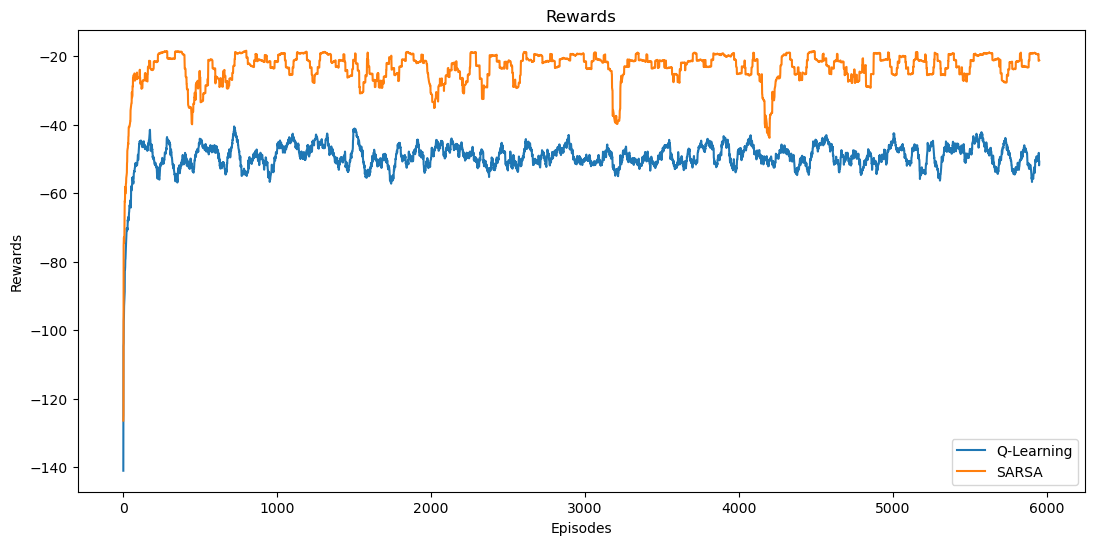

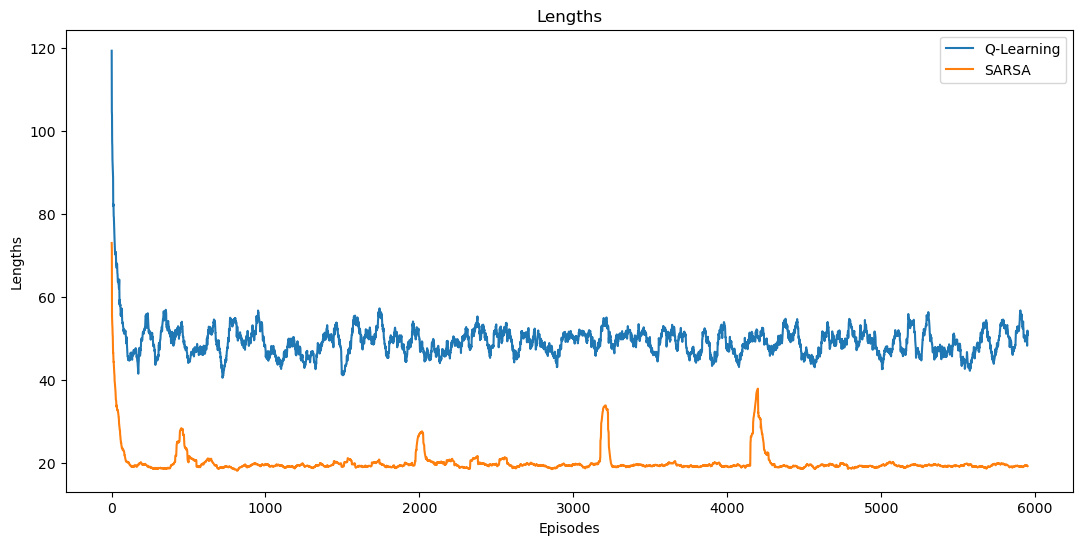

In [28]:
envname = "Cliff-v0"
print()
print("###########################################################")
print("################ Environment: Cliff-v0 ####################")
print("###########################################################\n")

env = gym.make(envname)
env.render()

# Learning parameters
episodes = 6000
ep_limit = 50
alpha = .3
gamma = .9
epsilon = .1
temp = 1

rewser = []
lenser = []

litres = np.arange(1, episodes + 1)  # Learning iteration values
window = 50  # Rolling window

t = timer()

# Q-Learning
#_, rews, lengths = q_learning(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
_, rews, lengths = q_learning(env, episodes, alpha, gamma, softmax, temp)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "ls": "-", "label": "Q-Learning"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "ls": "-", "label": "Q-Learning"})

# SARSA
_, rews, lengths = sarsa(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
#_, rews, lengths = q_learning(env, episodes, alpha, gamma, softmax, temp)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "label": "SARSA"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "label": "SARSA"})

print("Execution time: {0}s".format(round(timer() - t, 4)))

plot(rewser, "Rewards", "Episodes", "Rewards")
plot(lenser, "Lengths", "Episodes", "Lengths")

Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend.

**Algorithms Reward comparison**
<img src="images/results-reward.png" width="600">

**Algorithms Episode Length comparison**
<img src="images/results-length.png" width="600">